## Grab historical data (4/12/22 - 7/19/22) csv file from github

In [1]:
import pandas as pd

# url points to where the data is saved in github
url = 'https://raw.githubusercontent.com/primitivefinance/pool-analytics/main/historical_data/rmm_swap_data.csv'

raw_swap_df  = pd.read_csv(url)

# set index to timestamp for time series analysis.
raw_swap_df = raw_swap_df.set_index('timestamp')

In [2]:
# filter dataframe by inidividual pool
# hp_pool = '0x3f30f0d4cc68008c126445aa48f352476dfaf6eef720301e7e3e12fec606fe5f'
# whale_pool = '0x0406da38d507a95e0cb6802d023a2932131cf8fd57b12faa82b3bec3307e5241' # whale pool, expired 7/10/22
# whale_pool = '0x50fea5c3d0c47f6e80acf0f9d061b5b9e4ae2ada7f52add1ce172c3a65d24d5e' # expires 7/19/22

# raw_swap_single_pool_df = raw_swap_df[raw_swap_df['pool.id'] == whale_pool]

#renaming for ease
raw_swap_single_pool_df = raw_swap_df

Tentatively I want to use what parameters?

## Bayesian Modeling

`Arviz` - Bayesian Inference visualization library \\
`cmdstanpy` - bayesian inference python wrapper over stan CLI \\

In [3]:
# install arviz (bayesian inference visualization) and cmdstanpy (bayesian modeling)
!pip install arviz
!pip install --upgrade cmdstanpy


# REVIEW NOTES FROM 4/11/21
# - https://github.com/stan-dev/example-models/blob/master/jupyter/covid-inf-rate/SantaClara_CmdStanPy.ipynb
# - https://cmdstanpy.readthedocs.io/en/stable-0.9.65/getting_started.html
# - stan reference manual - https://mc-stan.org/docs/2_26/reference-manual/hmc-chapter.html

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 73 kB 1.9 MB/s 
     |████████████████████████████████| 45 kB 3.0 MB/s 
  Attempting uninstall: cmdstanpy
    Found existing installation: cmdstanpy 0.9.5
    Uninstalling cmdstanpy-0.9.5:
      Successfully uninstalled cmdstanpy-0.9.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
fbprophet 0.7.1 requires cmdstanpy==0.9.5, but you have cmdstanpy 1.0.4 which is incompatible.


In [4]:
import cmdstanpy
# downloads CmdStan from GitHub and builds the CmdStan utilities.
cmdstanpy.install_cmdstan() #need cmdstan for cmdstanpy to run on, note this step takes a while to finish.

Installing CmdStan version: 2.30.0
Install directory: /root/.cmdstan
Download successful, file: /tmp/tmpgxzjy0lj
Extracting distribution
Unpacked download as cmdstan-2.30.0
Building version cmdstan-2.30.0, may take several minutes, depending on your system.
Test model compilation
Installed cmdstan-2.30.0


True

In [5]:
# check that cmdstanpy is latest version. Sometimes there is a colab bug here if cmdstanpy is not upgraded to latest version.
cmdstanpy.__version__

'1.0.4'

In [6]:
raw_swap_single_pool_df.columns

Index(['riskyForStable', 'deltaOut', 'tau', 'totalUnderlying', 'totalQuote',
       'totalLiquidity', 'pool.id', 'pool.liquidity', 'pool.strike',
       'pool.invariant', 'pool.sigma', 'pool.maturity', 'pool.initialQuote',
       'pool.initialUnderlying', 'pool.initialLiquidity', 'pool.initialTau',
       'pool.feesCollectedQuote', 'pool.feesCollectedUnderlying',
       'pool.maturity_utc', 'pool.createdAtTimestamp_utc',
       'pool.initialTau_utc', 'tau_yrs', 'pool.initialTau_years',
       'swap_vol_cum', 'swap_count_cum', 'pool_name', 'spot_price', 'tvl',
       'initial_tvl', 'total_fees_usdc', 'pool.duration_utc',
       'totalUnderlying_usdc', 'totalQuote_usdc',
       'initialUnderlyingPerLiquidity', 'initialQuotePerLiquidity',
       'currentUnderlyingPerLiquidity', 'currentUnderlyingPerLiquiditySpot',
       'currentQuotePerLiquidity', 'currentLPT_usdc'],
      dtype='object')

In [7]:
# check liquidity utilization calculation
(raw_swap_single_pool_df['deltaOut'] / raw_swap_single_pool_df['tvl']).head(5)

timestamp
2022-04-12 09:06:00    0.110621
2022-04-12 21:00:00    0.066238
2022-04-13 05:24:00    0.999324
2022-04-18 01:45:00    0.060504
2022-04-18 07:48:00    0.047358
dtype: float64

In [8]:
# prepare data to put into dictionary. Data needs to be in dictionary format to use in Stan
index_count = len(raw_swap_single_pool_df.index)

x_vals = [x for x in range(0,index_count)]
y1 = (raw_swap_single_pool_df['tau_yrs']).fillna(0).tolist()
y2 = (raw_swap_single_pool_df['deltaOut'] / raw_swap_single_pool_df['tvl']).fillna(0).tolist()

keys = ['N', 'y1', 'y2']
swap_data_dict = dict(zip(keys,[index_count, y1, y2]))

In [9]:
#create basic STAN model that gives a posterior distribution based on the input data priors

my_model = """
data { 
  int<lower=0> N;
  vector[N] y1;
  vector[N] y2;
} 

parameters {
  real<lower=0, upper=1> theta1;
  real<lower=0, upper=1> theta2;
} 

model {
  theta1 ~ normal(0, 1); # theta is defined as a prior normal distribution
  y1 ~ normal(theta1, 1);

  theta2 ~ normal(0, 1);
  y2 ~ normal(theta2, 1);
}
"""

with open("my_model.stan", "w") as f:
    f.write(my_model)

model = cmdstanpy.CmdStanModel(stan_file="my_model.stan")
fit = model.sample(chains=4, inits=50, iter_warmup=50, thin=2, data=swap_data_dict, output_dir="./")

13:04:09 - cmdstanpy - INFO - compiling stan file /content/my_model.stan to exe file /content/my_model
13:04:29 - cmdstanpy - INFO - compiled model executable: /content/my_model
13:04:29 - cmdstanpy - WARNING - Stan compiler has produced 1 warnings:
13:04:29 - cmdstanpy - WARNING - 
--- Translating Stan model to C++ code ---
bin/stanc  --o=/content/my_model.hpp /content/my_model.stan
Warning in '/content/my_model.stan', line 14, column 25: Comments beginning
    with # are deprecated and this syntax will be removed in Stan 2.32.0. Use
    // to begin line comments; this can be done automatically using the
    auto-format flag to stanc

--- Compiling, linking C++ code ---
g++ -std=c++1y -pthread -D_REENTRANT -Wno-sign-compare -Wno-ignored-attributes      -I stan/lib/stan_math/lib/tbb_2020.3/include    -O3 -I src -I stan/src -I lib/rapidjson_1.1.0/ -I lib/CLI11-1.9.1/ -I stan/lib/stan_math/ -I stan/lib/stan_math/lib/eigen_3.3.9 -I stan/lib/stan_math/lib/boost_1.78.0 -I stan/lib/stan_math

chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

13:04:30 - cmdstanpy - INFO - CmdStan done processing.


In [10]:
fit.summary()

,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
name,,,,,,,,,
lp__,-24.563200,0.051516,1.276050,-26.978600,-24.207800,-23.339500,613.544,1319.45,1.00678
theta1,0.050729,0.001027,0.034655,0.005543,0.045237,0.117389,1138.720,2448.86,0.99939
theta2,0.076784,0.001311,0.044255,0.010736,0.073204,0.156671,1139.570,2450.70,1.00410


In [11]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np

In [12]:
inf_data = az.convert_to_inference_data(fit)

In [13]:
# rename variables for clarity
inf_data.rename({"theta1": "tau", "theta2": "liquidity_utilization"}, inplace=True)

In [14]:
print(f"a value of .02 tau = {(.02 * 31536000) / (60*60*24)} days")

a value of .02 tau = 7.3 days


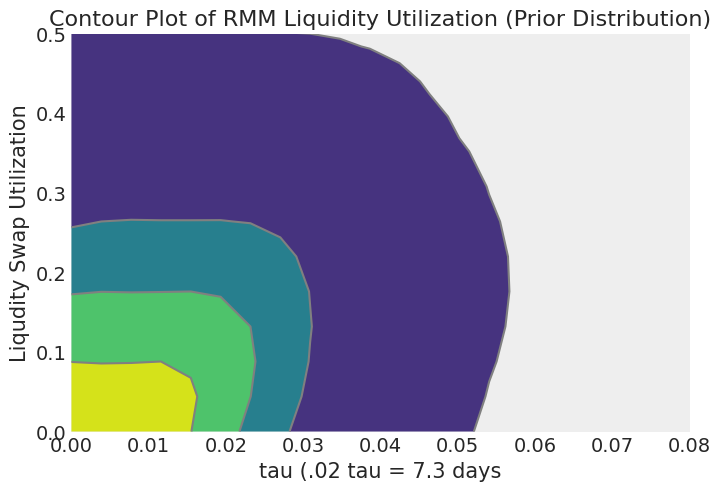

In [28]:
az.style.use("arviz-darkgrid")
az.plot_kde(y1, y2, hdi_probs= [0.25, .5, .75, .95])
plt.title("Contour Plot of RMM Liquidity Utilization (Prior Distribution)")
plt.xlabel("tau (.02 tau = 7.3 days")
plt.ylabel("Liqudity Swap Utilization")
plt.xlim([0, .08])
plt.ylim([0, .5])
plt.show()

In [29]:
print(f"a value of .02 tau = {(.02 * 31536000) / (60*60*24)} days")

a value of .02 tau = 7.3 days


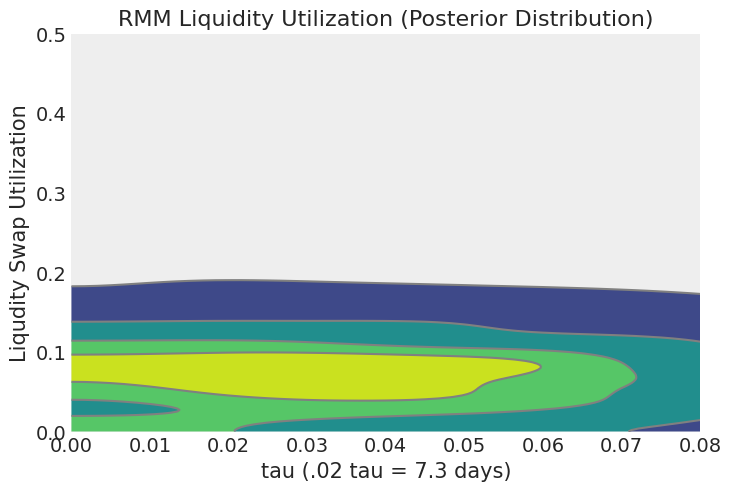

In [30]:
az.plot_kde(inf_data.posterior.tau, inf_data.posterior.liquidity_utilization, hdi_probs= [0.25, .5, .75, .95])
plt.title("RMM Liquidity Utilization (Posterior Distribution)")
plt.xlabel("tau (.02 tau = 7.3 days)")
plt.ylabel("Liqudity Swap Utilization")
plt.xlim([0, .08])
plt.ylim([0, .5])
plt.show()

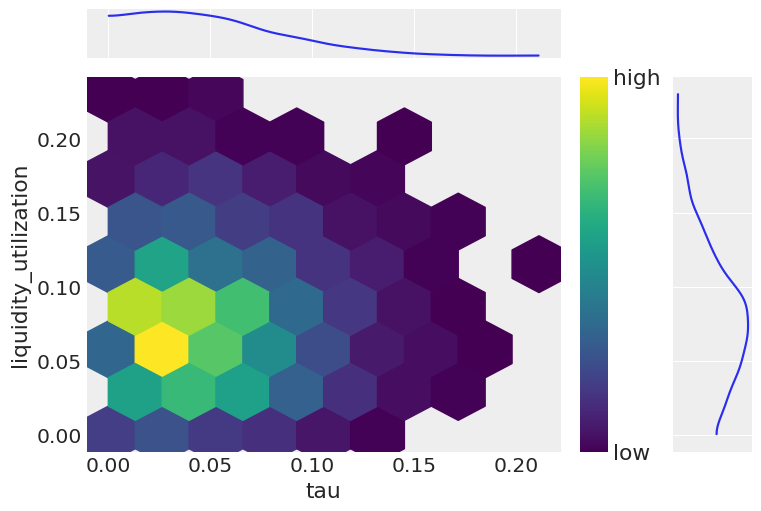

In [23]:
az.plot_pair(
    inf_data,
    var_names=["tau", "liquidity_utilization"],
    marginals=True,
    kind='hexbin',
    figsize=(7.5,5),
    colorbar=True
)

plt.show()